In [1]:
'''
@author: Kamuz Bohdan
'''

'\n@author: Kamuz Bohdan\n'

In [2]:
''' Настройка темы '''

original_color = (10 / 256, 10 / 256, 10 / 256)
train_color = (114 / 256, 93 / 256, 191 / 256)
validation_color = (242/ 256, 128 / 256, 18/ 256)
test_color = (47/ 256, 165/ 256, 14/ 256)

In [3]:
# %pip install requests
# %pip install pandas
# %pip install numpy
# %pip install keras
# %pip install matplotlib


> 1. Изучить документацию RESTful API Binance (https://binance-docs.github.io/apidocs/spot/en/) и написать скрипт на Python с использованием библиотеки Requests, чтобы получить данные о котировках криптовалют. Сохранить полученные данные в формате CSV.

In [4]:
# импортирование необходимых библиотек
import os
import re
import math
import csv
import requests

url = 'https://api.binance.com/api/v3/klines'

headers = [
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_asset_volume', 'number_of_trades',
    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
]

def parse_timeframe(timeframe):
    '''
    Функция для разбора таймфрейма на составляющие
    '''
    time = int(re.findall("[0-9]+", timeframe)[0])
    frame = str(re.findall("[a-zA-Z]+", timeframe)[0])
    if frame == 'm':
        divider = 60 * 1000
    elif frame == 'h':
        divider = 60 * 60 * 1000
    elif frame == 'd':    
        divider = 60 * 60 * 24 * 1000
    return time, divider

def calculate_delta_and_iterations(start_time_ms, end_time_ms, timeframe):
    '''
    Функция для расчета дельты и итераций для определения промежутка времени в миллисекундах
    '''
    time, divider = parse_timeframe(timeframe)
    delta = int((end_time_ms - start_time_ms) / divider / time)
    limit = 1000
    rest = delta % limit
    iterations = [(limit, math.ceil(delta / limit))]
    if rest > 0:
        iterations.append((rest, 1))
    return iterations, time, divider

def fetch_data(symbol, timeframe, start_time_ms, end_time_ms, path='data/'):
    '''
    Функция обходит лимит в 1000 баров
    '''
    if not os.path.exists(path):
        os.makedirs(path)

    iterations, time, divider = calculate_delta_and_iterations(
        start_time_ms, end_time_ms, timeframe)

    whole_data = []
    timestamp = start_time_ms

    for (pack, iterations_count) in iterations:
        for _ in range(iterations_count):
            params = {
                'symbol': symbol,
                'interval': timeframe,
                'startTime': timestamp,
                'limit': pack
            }
            response = requests.get(url, params=params)
            whole_data.extend(response.json())

            timestamp += (divider * pack)

    with open(f'{path}/{symbol.lower()}_{timeframe}_data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        for row in whole_data:
            writer.writerow(row[:len(headers)])


In [5]:
# Устанавливаем параметры: временные рамки, время начала и окончания и запускаем функцию получения и сохранения данных

import datetime # модуль для работы с датой и временем

# Начальное и конечное время для получения данных
start_time = "2022-02-10 00:00:00"  # формат: "год-месяц-день час:минута:секунда"
end_time = "2023-03-10 00:00:00"  # формат: "год-месяц-день час:минута:секунда"

# Временной интервал и лимит для получения данных
timeframe = "1h"  # формат: "число + буква, например "1h" для получения данных за 1 час

# Начальное и конечное время в миллисекундах
start_time_ms = int(datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
end_time_ms = int(datetime.datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S").timestamp() * 1000)

# Котировка и путь
symbol = 'ATOMUSDT'
path = 'data/'

fetch_data(symbol, timeframe, start_time_ms, end_time_ms)

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler



2023-04-11 23:10:18.358456: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-11 23:10:18.440551: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-11 23:10:18.442044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 23:10:19.354366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


> 2. Загрузить полученный CSV-файл с данными в Python с использованием библиотеки Pandas и выполнить предварительную обработку данных (например, удаление пропусков, преобразование даты и времени, масштабирование).

In [7]:
# Считывание файла csv
df = pd.read_csv('data/atomusdt_1h_data.csv')
print(df.head()) #7 columns, including the Date. 

# Отделение дат для будущего построения графика
train_dates = pd.to_datetime(df['open_time'], unit='ms')
print(train_dates.tail(15)) #Check last few dates. 

# Переменные для обучения
cols = list(df)[1:-1]

print(cols)


       open_time   open   high    low  close     volume     close_time  \
0  1644451200000  30.91  30.94  30.40  30.43   79166.42  1644454799999   
1  1644454800000  30.44  30.53  30.16  30.40   60120.00  1644458399999   
2  1644458400000  30.40  30.55  30.12  30.15  110625.34  1644461999999   
3  1644462000000  30.14  30.35  30.05  30.26  125149.22  1644465599999   
4  1644465600000  30.26  30.36  30.11  30.26   54178.99  1644469199999   

   quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
0        2.420306e+06              7532                     33127.13   
1        1.824581e+06              5363                     30980.79   
2        3.356950e+06              6081                     65155.87   
3        3.777515e+06              7964                     71415.06   
4        1.637563e+06              2519                     26069.17   

   taker_buy_quote_asset_volume  ignore  
0                  1.012805e+06       0  
1                  9.405935e+05       

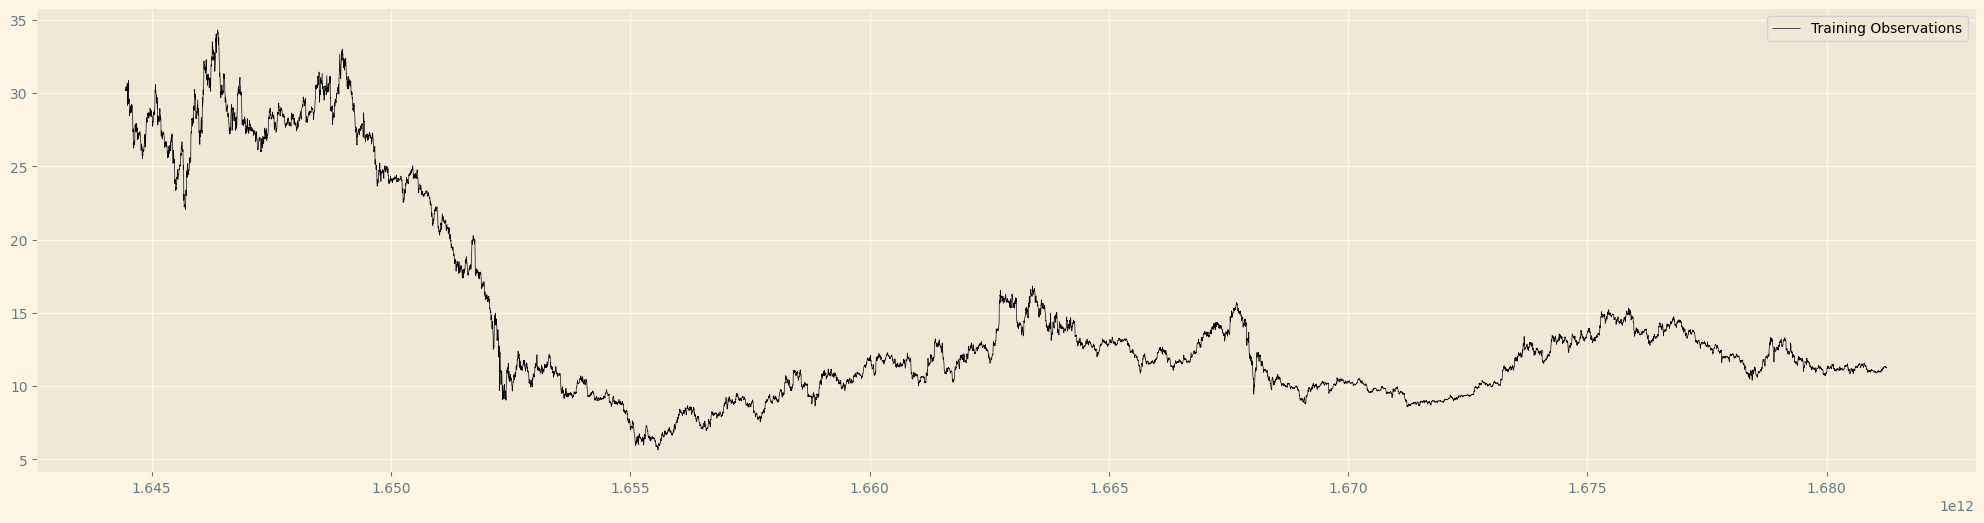

In [22]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(25,6))
plt.grid(which='minor')

plt.plot(df['open_time'], df['close'], color=original_color, linewidth=0.5) # График фактических значений
plt.legend(['Training Observations','Training Predictions']) # Наименование графиков в легенде

In [9]:

# Часть содержащая только учебные данные - 10 столбцов
df_for_training = df[cols].astype(float)

# LSTM использует сигмоид и тангенс, которые чувствительны к величине, поэтому значения должны быть нормализованы
# нормализуйте набор данных
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)



> 3. С использованием библиотеки NumPy, разделить данные на обучающую и тестовую выборки.

In [10]:

# Как и требуется для LSTM-сетей, мы должны преобразовать входные данные в n_samples x timesteps x n_features. 
# В нашем примере n_features равно 5. Сделаем timesteps = 14 (данные прошлых дней, используемые для обучения). 

# Пустые списки, которые будут заполнены с помощью форматированных учебных данных
trainX = []
trainY = []

n_future = 1   # Количество баров, которые мы хотим заглянуть в будущее на основе прошедших дней.
n_past = 14  # Количество прошлых баров, которые мы хотим использовать для прогнозирования будущего.

# Переформатируем входные данные в форму: (n_samples x timesteps x n_features)
# В моем примере df_for_training_scaled имеет форму (10224, 10)
# 10224 относится к количеству точек данных, а 10 относится к столбцам (мультипеременным).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (10210, 14, 10).
trainY shape == (10210, 1).


> 4. Создать и обучить LSTM-модель с использованием библиотеки Keras или TensorFlow на основе подготовленных данных. Подобрать архитектуру и гиперпараметры модели, чтобы достичь наилучшего качества прогнозирования.

In [11]:

# В моем случае trainX имеет форму (10210, 14, 10). 
# 10210, потому что мы смотрим на 14 значений назад (10224 - 14 = 10210). 
# Мы не можем оглянуться на 14 дней назад, пока не дойдем до 15-го дня. 
# Также, trainY имеет форму (10210в, 1). Наша модель предсказывает только одно значение, но 
# для этого предсказания нужно несколько переменных (10 в моем примере). 
# Вот почему мы можем предсказать только один день после обучения, день, после которого заканчиваются наши данные.
# Чтобы предсказать больше дней в будущем, нам нужны все 5 переменных, которых у нас нет. 
# Нам нужно предсказать все переменные, если мы хотим это сделать. 

# определим модель

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            19200     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


In [12]:
# настройка модели
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/5
575/575 [==============================] - 9s 12ms/step - loss: 0.0731 - val_loss: 0.0012
Epoch 2/5
575/575 [==============================] - 6s 11ms/step - loss: 0.0333 - val_loss: 0.0019
Epoch 3/5
575/575 [==============================] - 6s 11ms/step - loss: 0.0325 - val_loss: 7.0952e-04
Epoch 4/5
575/575 [==============================] - 7s 11ms/step - loss: 0.0317 - val_loss: 5.9582e-04
Epoch 5/5
575/575 [==============================] - 7s 12ms/step - loss: 0.0306 - val_loss: 0.0029


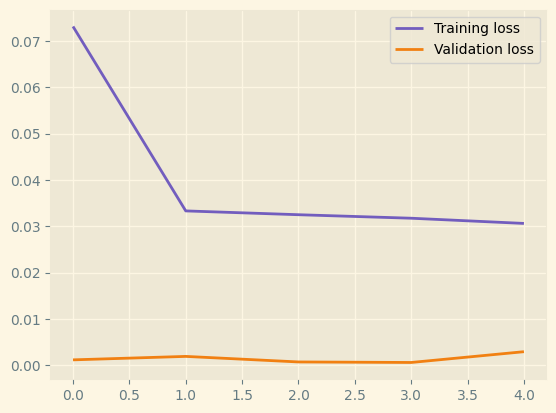

In [23]:

plt.plot(history.history['loss'], label='Training loss',  color=train_color)
plt.plot(history.history['val_loss'], label='Validation loss',  color=validation_color)
plt.legend()


In [35]:

# Прогнозирование...
n_past = 24 * 30]
n_for_prediction = n_past + 24

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_for_prediction, freq='H').tolist()
print(predict_period_dates)


[Timestamp('2023-03-13 00:00:00', freq='H'), Timestamp('2023-03-13 01:00:00', freq='H'), Timestamp('2023-03-13 02:00:00', freq='H'), Timestamp('2023-03-13 03:00:00', freq='H'), Timestamp('2023-03-13 04:00:00', freq='H'), Timestamp('2023-03-13 05:00:00', freq='H'), Timestamp('2023-03-13 06:00:00', freq='H'), Timestamp('2023-03-13 07:00:00', freq='H'), Timestamp('2023-03-13 08:00:00', freq='H'), Timestamp('2023-03-13 09:00:00', freq='H'), Timestamp('2023-03-13 10:00:00', freq='H'), Timestamp('2023-03-13 11:00:00', freq='H'), Timestamp('2023-03-13 12:00:00', freq='H'), Timestamp('2023-03-13 13:00:00', freq='H'), Timestamp('2023-03-13 14:00:00', freq='H'), Timestamp('2023-03-13 15:00:00', freq='H'), Timestamp('2023-03-13 16:00:00', freq='H'), Timestamp('2023-03-13 17:00:00', freq='H'), Timestamp('2023-03-13 18:00:00', freq='H'), Timestamp('2023-03-13 19:00:00', freq='H'), Timestamp('2023-03-13 20:00:00', freq='H'), Timestamp('2023-03-13 21:00:00', freq='H'), Timestamp('2023-03-13 22:00:00'

In [36]:

# Прогнозирование
prediction = model.predict(trainX[-n_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

# Выполните обратное преобразование для возврата к исходному диапазону.
# Поскольку мы использовали множество переменных для преобразования, обратное преобразование ожидает тех же размеров
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]



24/24 [==============================] - 0s 3ms/step


> 5. Оценить качество модели на тестовой выборке, используя подходящие метрики, такие как среднеквадратичная ошибка (MSE) или средняя абсолютная ошибка (MAE).

In [52]:
from sklearn.metrics import mean_squared_error

# # Вычисляем среднеквадратичную ошибку
mean_squared_error(y_true, y_pred).numpy()

NameError: name 'y_true' is not defined

In [37]:
# Преобразование временной метки в дату
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'open_time':np.array(predict_period_dates), 'open':y_pred_future})
df_forecast['open_time']=pd.to_datetime(df_forecast['open_time'])


original = df[['open_time', 'open']].copy()
original['open_time']=pd.to_datetime(original['open_time'], unit='ms')
original = original.loc[original['open_time'] >= df_forecast['open_time'][0]]

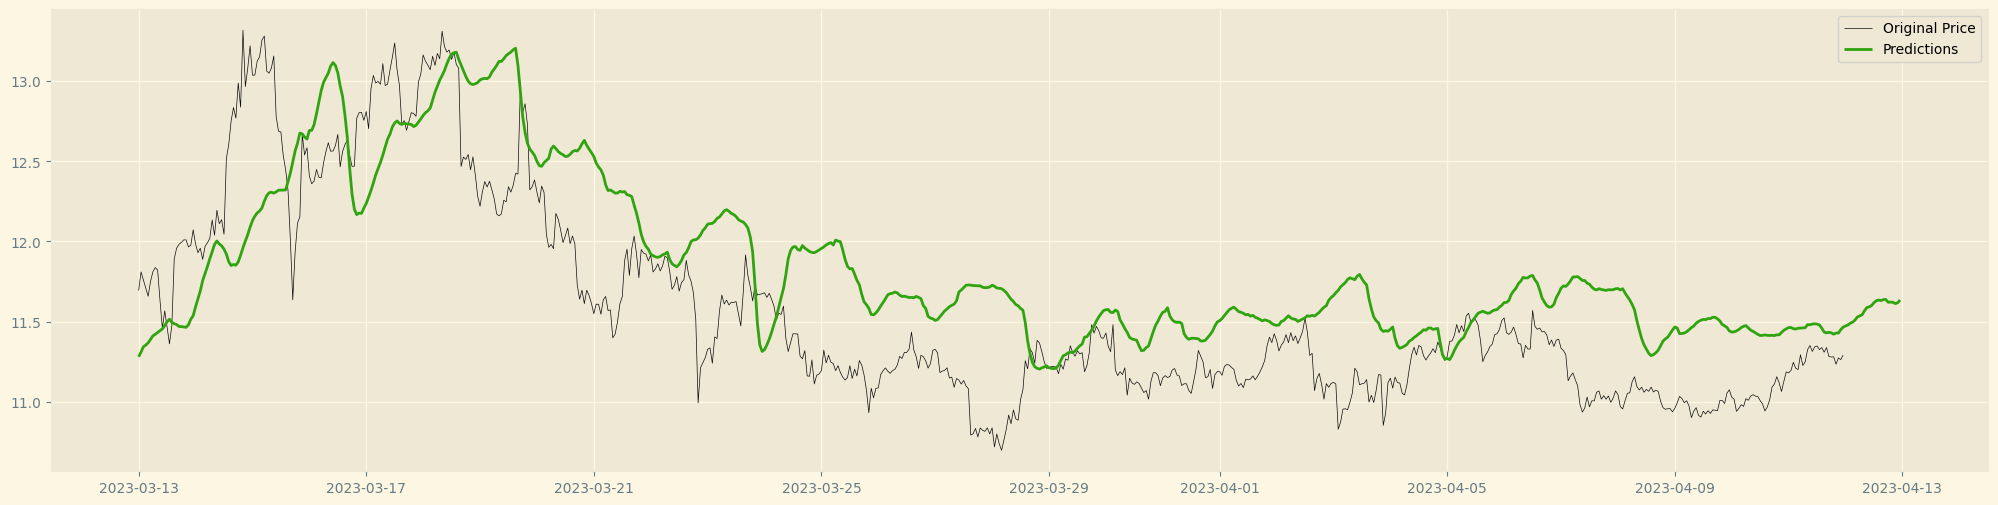

In [38]:
plt.figure(figsize=(25,6))
plt.grid(which='minor')

plt.plot(original['open_time'], original['open'], color=original_color, linewidth=0.5) # График фактических значений
plt.plot(df_forecast['open_time'], df_forecast['open'], color=test_color, linewidth=2) # График предсказаний
plt.legend(['Original Price','Predictions']) # Наименование графиков в легенде